In [1]:
import re
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from ipywidgets import interact

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import matplotlib
import matplotlib.pyplot as plt
import json
%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

from pandas.plotting import scatter_matrix
from datetime import datetime, timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [9]:
p_df = pd.read_csv('pokemon.csv')
c_df = pd.read_csv('combats.csv')

display(p_df.head(5))
display(c_df.head(5))

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [8]:
display(p_df.describe())
display(c_df.describe())

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


,First_pokemon,Second_pokemon,Winner
count,50000.000000,50000.000000,50000.000000
mean,400.495640,403.159660,408.890100
std,229.549429,230.083644,231.159961
min,1.000000,1.000000,1.000000
25%,203.000000,207.000000,206.000000
50%,399.000000,402.000000,422.000000
75%,597.250000,602.000000,606.000000
max,800.000000,800.000000,800.000000


In [16]:
display(p_df['Class 1'].unique())
display(p_df['Class 2'].unique())

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

array(['Poison', nan, 'Flying', 'Dragon', 'Ground', 'Fairy', 'Grass',
       'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark', 'Water',
       'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'], dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1097a0da0>]],
      dtype=object)

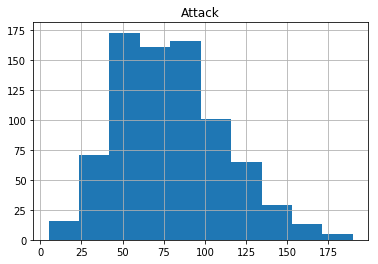

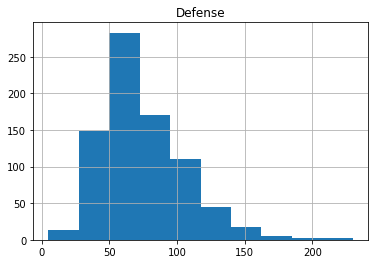

In [17]:
p_df.hist(column = 'Attack')
p_df.hist(column = 'Defense')

Text(0.5, 1.0, 'Sp. Atk + Sp. Def')

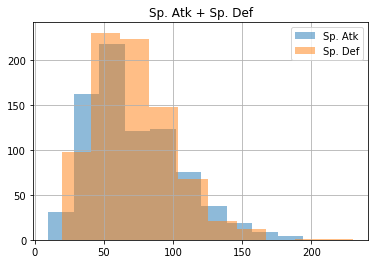

In [38]:
ax = p_df.hist(column='Sp. Atk', alpha = 0.5)
p_df.hist(column='Sp. Def', ax = ax, alpha = 0.5)
plt.legend(['Sp. Atk', 'Sp. Def'])
plt.title("Sp. Atk + Sp. Def")

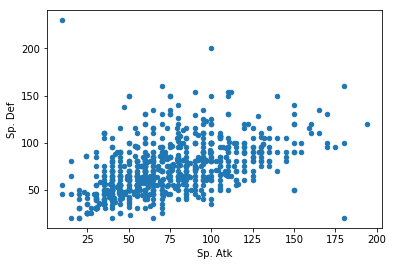

In [39]:
p_df.plot(kind = 'scatter', x = 'Sp. Atk', y = 'Sp. Def')

In [55]:
p_df['Attack/Defense'] = p_df['Attack'] / p_df['Defense']
display(p_df.sort_values(by=['Attack/Defense'], ascending = False)[:3])
print("list the names of the 3 Pokémon with highest attack-over-defense ratio:\n")
print("\n".join(p_df.sort_values(by=['Attack/Defense'], ascending = False)[:3]['Name'].tolist()))
display(p_df.sort_values(by=['Attack/Defense'], ascending = True)[:3])
print("list the names of the 3 Pokémon with lowest attack-over-defense ratio:\n")
print("\n".join(p_df.sort_values(by=['Attack/Defense'], ascending = True)[:3]['Name'].tolist()))


,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense
429,430,DeoxysAttack Forme,Psychic,NaN,50,180,20,180,20,150,True,9.00
347,348,Carvanha,Water,Dark,45,90,20,65,20,65,False,4.50
19,20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,False,3.75


list the names of the 3 Pokémon with highest attack-over-defense ratio:

DeoxysAttack Forme
Carvanha
Mega Beedrill


,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense
230,231,Shuckle,Bug,Rock,20,10,230,10,230,5,False,0.043478
139,140,Magikarp,Water,NaN,20,10,55,15,20,80,False,0.181818
484,485,Bronzor,Steel,Psychic,57,24,86,24,86,23,False,0.279070


list the names of the 3 Pokémon with lowest attack-over-defense ratio:

Shuckle
Magikarp
Bronzor


In [79]:
display(c_df.head(5))

print('list the names of the 10 Pokémon with the largest number of victories.\n')
top_df = c_df.groupby('Winner').size().reset_index(name='counts').sort_values(by='counts', ascending = False)[:10]
print("\n".join(top_df.merge(p_df, left_on = 'Winner', right_on = 'pid')['Name'].tolist()))

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


list the names of the 10 Pokémon with the largest number of victories.

Mewtwo
Aerodactyl
Infernape
Jirachi
Deoxys Speed Forme
Slaking
Murkrow
Mega Absol
Mega Houndoom
Mega Aerodactyl


,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False,1.000000
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False,0.984127
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False,0.987952
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False,0.813008
48,49,Oddish,Grass,Poison,45,50,55,75,65,30,False,0.909091


,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense
80,81,Geodude,Rock,Ground,40,80,100,30,30,20,False,0.800000
81,82,Graveler,Rock,Ground,55,95,115,45,45,35,False,0.826087
82,83,Golem,Rock,Ground,80,120,130,55,65,45,False,0.923077
103,104,Onix,Rock,Ground,35,45,160,30,45,70,False,0.281250
149,150,Omanyte,Rock,Water,35,40,100,90,55,35,False,0.400000


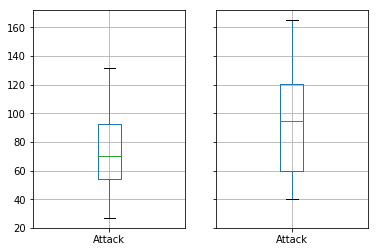

In [110]:
grass_class = p_df[(p_df['Class 1'] == 'Grass') | (p_df['Class 2'] == 'Grass') &
                   ~((p_df['Class 1'] != 'Rock') | (p_df['Class 2'] == 'Rock'))]
rock_class = p_df[(p_df['Class 1'] == 'Rock') | (p_df['Class 2'] == 'Rock') &
                  ~((p_df['Class 1'] != 'Grass') | (p_df['Class 2'] == 'Grass'))]
display(grass_class.head(5))
display(rock_class.head(5))

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
grass_class.boxplot(column = 'Attack', return_type='axes', ax = ax1)
rock_class.boxplot(column = 'Attack', ax = ax2)

In [113]:
spark.sql("""
    SELECT Pokemons.Winner, Pokemons.Name, COUNT(*) as TotalWins
    FROM Combats
    INNER JOIN Pokemons on Pokemons.pid = Combats.Winner
    GROUP BY Pokemnon.Winner, Pokemons.Name
    ORDER BY TotalWins DESC
""")

AnalysisException: 'Table or view not found: Combats; line 3 pos 9'

In [209]:
X_ext = c_df.merge(p_df, left_on='First_pokemon', right_on='pid') \
    .merge(p_df, left_on='Second_pokemon', right_on='pid', suffixes=('_x', '_y'))
X = X_ext.drop(columns=['Winner', 'First_pokemon', 'Second_pokemon', 'pid_x', 'pid_y', 'Name_x', 'Name_y', 'Attack/Defense_x', 'Attack/Defense_y'])

categories = pd.unique(p_df[['Class 1', 'Class 2']].values.ravel('K'))[:-1]

X['Class 1_x'] = pd.Categorical(X['Class 1_x'], categories=categories).codes
X['Class 1_y'] = pd.Categorical(X['Class 1_y'], categories=categories).codes

X['Class 2_x'] = pd.Categorical(X['Class 2_x'], categories=categories).codes
X['Class 2_y'] = pd.Categorical(X['Class 2_y'], categories=categories).codes

display(X)
Y = X_ext['Winner'] == X_ext['First_pokemon']

,Class 1_x,Class 2_x,HP_x,Attack_x,Defense_x,Sp. Atk_x,Sp. Def_x,Speed_x,Legendary_x,Class 1_y,Class 2_y,HP_y,Attack_y,Defense_y,Sp. Atk_y,Sp. Def_y,Speed_y,Legendary_y
0,11,7,50,64,50,45,50,41,False,0,15,70,70,40,60,40,60,False
1,9,-1,70,80,50,35,35,35,False,0,15,70,70,40,60,40,60,False
2,2,7,110,78,73,76,71,60,False,0,15,70,70,40,60,40,60,False
3,6,17,50,65,107,105,107,86,False,0,15,70,70,40,60,40,60,False
4,4,-1,73,115,60,60,60,90,False,0,15,70,70,40,60,40,60,False
5,0,16,44,50,91,24,86,10,False,0,15,70,70,40,60,40,60,False
6,1,4,62,50,58,73,54,72,False,0,15,70,70,40,60,40,60,False
7,10,-1,70,55,95,95,110,65,False,0,15,70,70,40,60,40,60,False
8,2,-1,80,92,65,65,80,68,False,0,15,70,70,40,60,40,60,False
9,0,-1,100,100,125,110,50,50,False,0,15,70,70,40,60,40,60,False


In [210]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [211]:
N = len(X)
N

50000

In [212]:
train_size = int(N * 0.9)
test_size = N - train_size
permutation = np.random.permutation(N)
train_set_index = permutation[:train_size]
test_set_index = permutation[train_size:]

print(train_set_index)
print(test_set_index)

[21675 20249 15069 ... 36014 19785 39193]
[42619  7774 43972 ... 46959 47569 25391]


In [213]:
X_train = X.iloc[train_set_index]
Y_train = Y.iloc[train_set_index]

X_test = X.iloc[test_set_index]
Y_test = Y.iloc[test_set_index]

In [231]:
n_estimators = [10, 25, 50, 100]
max_depths = [2, 4, 10]

def k_fold(X, Y, K):
    permutation = np.random.permutation(N)
    for k in range(K):
        X_test = X.iloc[permutation[k * test_size : (k + 1) * test_size]]
        Y_test = Y.iloc[permutation[k * test_size : (k + 1) * test_size]]
        
        X_train = X.iloc[permutation[:k*test_size].tolist() + permutation[(k + 1)*test_size:].tolist()]
        Y_train = Y.iloc[permutation[:k*test_size].tolist() + permutation[(k + 1)*test_size:].tolist()]
        yield(X_train, Y_train, X_test, Y_test)

best_acc = 0
best_n_est = 0
best_max_depth = 0
for n_estimator in n_estimators:
    for max_depth in max_depths:
        clf = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, random_state=0)
        accuracies = []
        for (X_train, Y_train, X_test, Y_test) in k_fold(X, Y, 5):
            clf.fit(X_train, Y_train)
            accuracies.append((clf.predict(X_test) == Y_test).sum() / test_size)
  
        accuracy = np.mean(accuracies)
        print(n_estimator, max_depth, accuracy)
        if accuracy > best_acc:
            best_acc = accuracy
            best_n_est = n_estimator
            best_max_depth = max_depth
            
print('Best accuracy: ', best_acc)
print('Best number of estimators: ', best_n_est)
print('Best max depth: ', best_max_depth)
    

10 2 0.7933200000000001
10 4 0.85808
10 10 0.9268000000000001
25 2 0.8106
25 4 0.857
25 10 0.9296399999999998
50 2 0.80632
50 4 0.86784
50 10 0.93212
100 2 0.80808
100 4 0.87744
100 10 0.93596
Best accuracy:  0.93596
Best number of estimators:  100
Best max depth:  10


In [234]:
forest = RandomForestClassifier(n_estimators=best_n_est, max_depth=best_max_depth, random_state=0)
forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Feature ranking:
1. feature 7 (Speed_x) (0.367536)
2. feature 16 (Speed_y) (0.348282)
3. feature 12 (Attack_y) (0.041669)
4. feature 3 (Attack_x) (0.038579)
5. feature 5 (Sp. Atk_x) (0.029665)
6. feature 14 (Sp. Atk_y) (0.026784)
7. feature 2 (HP_x) (0.020175)
8. feature 11 (HP_y) (0.017509)
9. feature 6 (Sp. Def_x) (0.017483)
10. feature 15 (Sp. Def_y) (0.017186)
11. feature 4 (Defense_x) (0.013039)
12. feature 13 (Defense_y) (0.012665)
13. feature 10 (Class 2_y) (0.011253)
14. feature 1 (Class 2_x) (0.010887)
15. feature 9 (Class 1_y) (0.008595)
16. feature 0 (Class 1_x) (0.007540)
17. feature 8 (Legendary_x) (0.006054)
18. feature 17 (Legendary_y) (0.005099)


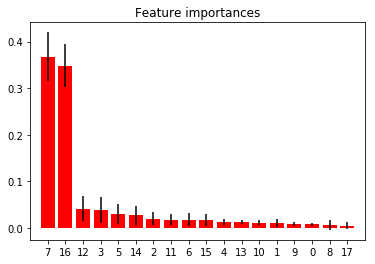

In [244]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%s) (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

(5 points) Compute the winning ratio (number of wins divided by number of battles) for all Pokémon. Show the 10 Pokémon with the highest ratio and describe what they have in common with respect to their features. Discuss your results about feature importance from question 2.7 (regarding feature importance) in this context.l

In [274]:
top_df = c_df.groupby('Winner').size().reset_index(name='WinCount').sort_values(by='WinCount', ascending = False)

first_df = c_df.groupby('First_pokemon').size().reset_index(name='Battles').sort_values(by='Battles', ascending = False)
second_df = c_df.groupby('Second_pokemon').size().reset_index(name='Battles').sort_values(by='Battles', ascending = False)
merged = first_df.merge(second_df, left_on = 'First_pokemon', right_on='Second_pokemon')

merged['Battles'] = merged['Battles_x'] + merged['Battles_y']
merged = merged.drop(columns = ['Second_pokemon', 'Battles_x', "Battles_y"])

p_df_ext = p_df.merge(top_df, left_on='pid', right_on='Winner')
p_df_ext = p_df_ext.merge(merged, left_on='pid', right_on='First_pokemon')
p_df_ext = p_df_ext.drop(columns = ['First_pokemon', 'Winner'])

p_df_ext["WinninRatio"] = p_df_ext['WinCount'] / p_df_ext['Battles']

display(p_df_ext.head(5))



,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense,WinCount,Battles,WinninRatio
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False,1.000000,37,133,0.278195
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False,0.984127,46,121,0.380165
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False,0.987952,89,132,0.674242
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False,0.813008,70,125,0.560000
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False,1.209302,55,112,0.491071


In [277]:
p_df_ext.sort_values(by = 'WinninRatio', ascending = False)[:10]

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense,WinCount,Battles,WinninRatio
147,155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,False,1.588235,127,129,0.984496
499,513,Weavile,Dark,Ice,70,120,65,45,85,125,False,1.846154,116,119,0.974790
687,704,Tornadus Therian Forme,Flying,NaN,79,100,80,110,90,121,True,1.250000,121,125,0.968000
18,20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,False,3.750000,115,119,0.966387
146,154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,False,1.615385,136,141,0.964539
464,477,Mega Lopunny,Normal,Fighting,65,136,94,54,96,135,False,1.446809,124,129,0.961240
710,727,Greninja,Water,Dark,72,95,67,103,71,122,False,1.417910,122,127,0.960630
700,717,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,False,1.422222,118,123,0.959350
157,165,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,True,2.142857,119,125,0.952000
338,350,Mega Sharpedo,Water,Dark,70,140,70,110,65,105,False,2.000000,114,120,0.950000


In [278]:
p_df_ext.describe()

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Attack/Defense,WinCount,Battles,WinninRatio
count,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000
mean,402.873563,69.140485,79.007663,73.699872,72.839080,71.749681,68.443167,1.164354,63.856960,127.541507,0.501538
std,230.297452,25.348783,32.502566,30.879737,32.672868,27.248993,29.158076,0.552715,32.925941,11.397402,0.254993
min,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,0.181818,3.000000,92.000000,0.021739
25%,204.500000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,0.826267,36.000000,120.000000,0.284228
50%,403.000000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,1.076923,62.000000,128.000000,0.491071
75%,601.500000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,1.416026,91.000000,135.000000,0.717644
max,800.000000,255.000000,190.000000,230.000000,194.000000,200.000000,180.000000,9.000000,152.000000,164.000000,0.984496


In [293]:
wins = np.zeros(shape = (800, 800))

for row in c_df.iterrows():
    if row[1]['First_pokemon'] == row[1]['Winner']:
        wins[row[1]['First_pokemon'] - 1][row[1]['Second_pokemon'] - 1] += 1
    else:
        wins[row[1]['Second_pokemon'] - 1][row[1]['First_pokemon'] - 1] += 1

In [294]:
G = np.zeros(shape = (800, 800))

for i in range(800):
    for j in range(800):
        if wins[i][j] > wins[j][i]:
            G[i][j] = 1
        elif wins[i][j] > wins[j][i]:
            G[j][i] = 1

A = G + (G @ G)

In [310]:
scores = A.sum(axis = 1)
p_df[p_df['pid'].isin(np.argsort(scores)[-10:])]

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense
145,146,Vaporeon,Water,NaN,130,65,60,110,95,65,False,1.083333
152,153,Kabutops,Rock,Water,60,115,105,65,70,80,False,1.095238
153,154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,False,1.615385
161,162,Dragonite,Dragon,Flying,91,134,95,100,100,80,False,1.410526
162,163,Mewtwo,Psychic,NaN,106,110,90,154,90,130,True,1.222222
247,248,Houndoom,Dark,Fire,75,90,50,110,80,95,False,1.800000
392,393,Absol,Dark,NaN,65,130,60,75,60,75,False,2.166667
425,426,Rayquaza,Dragon,Flying,105,150,90,150,90,95,True,1.666667
428,429,Deoxys Normal Forme,Psychic,NaN,50,150,50,150,50,150,True,3.000000
430,431,Deoxys Defense Forme,Psychic,NaN,50,70,160,70,160,90,True,0.437500
